In [1]:
from scipy import stats
import numpy as np
import random
random.seed(0)

%matplotlib inline
import matplotlib.pyplot as plt


# Q-Learning

Q-learning algorithmes zijn gebaseerd op de TD-learning modellen die we eerder hebben besproken. Q-learning leert direct de associatie tussen states, actions en outcomes. De robot gaat nu dus niet alleen maar belongingen krijgen maar ook uitzoeken welke handeling de beste is geveven de situatie. 

Details over Q-learning zijn terug te vinden in de college slides en het hoofdstuk van Gureckis & Love [**computational reinforcement learning**](http://bradlove.org/papers/GureckisLovePress.pdf) en voor meer verdieping in het online boek van [**Sutton & Barto**](http://incompleteideas.net/book/bookdraft2018jan1.pdf) en dan met name hoofdstuk 6.

Het leren in deze opdracht speelt zich af in een simpel **Markov Decision Process** met de volgende structuur:

![](bandit_arms.png)

In deze taak moet de robot telkens uit een van de schatkisten iets pakken. In sommige schatkisten zit meer geld dan in anderen, maar de robot weet in het begin nog niks over de schatkisten, en verwacht er maar weinig van. In elke ronde wordt de uitkomst van een schatkist bepaald door een trekking van een waarde uit een normaalverdeling.

De uitkomsten van schatkisten verschillen in hun gemiddelde maar niet de variatie (standaard deviatie). 

**Let op:** In dit simpele experiment is er maar een state, waarin de robot telkens terugkeert na het maken van een keuze. Dit heeft als gevolg dat bij het leren geen rekening gehouden hoeft te worden met de actie die in de volgende state gemaakt wordt. De standaard prediction-error:

$$\delta = r_{t+1} + \gamma\ max_a\ Q(s_{t+1} , a) − Q(s_t , a_t)$$

verandert dus simpelweg in:
$$\delta = r_{t+1} − Q(s_t , a_t)$$

In het begin van het experiment heeft de robot geen enkele kennis van de wereld en geen enkele verwachtingen voor van het krijgen van beloningen. Voor elke schatkist geldt:

$$Q(1)=Q(2)=Q(3)=Q(4)=0$$



### Q1.a (2 punten)

Schrijf de Q-learning functie op die de nieuwe waarde Q uitrekent nadat de robot een schatkist heeft uitgekozen. Welke vrije variabele heeft deze functie en wat is zijn rol in leren? 


$$Q(s_t , a_t)  = Q(s_t , a_t) + \alpha(r_{t+1} − Q(s_t, a_t))$$
De vrije variabele is alpha. Deze alpha staat los van de rest van de formule. Een hogere alpha waarde betekent sneller 'leren'. De verwachtingswaardes (Q's) veranderen dus heviger.

### Q1.b (2 punten)

Stel de robot selecteert schatkist 1 en vindt twee munten. Wat is hierna de waarde van Q(1)? rapporteer dit voor
$\alpha=0.5$ en $\alpha=0.2$

De waarde van Q(1) wordt 1.0 en 0.4 voor alphas van 0.5 en 0.2, respectievelijk. Namelijk 1.0 = 0 + 0.5 (2 - 0) en 0.4 = 0 + 0.2 (2 - 0)

### Q1.c (7 punten)

Schrijf een functie `q_learn` die als input, alpha ($\alpha$), epsilon($\epsilon$) en rondes (trials) accepteert. De output van deze functie moet een lijst met $Q$ waarden zijn voor elke schatkist (1 t/m 4) in de wereld van de robot na het leren van een aantal rondes. We gaan er nu van uit dat de robot de $\epsilon$-greedy keuze regel toepast.

* Initieer de verwachtingen van de robot voor de 4 keuzes:
    * Q(1)=Q(2)=Q(3)=Q(4)=0. 
* Intieer total_score = 0
* Initieer de beloningen voor de 4 schatkisten:
    * K(1): mean=20, SD=4
    * K(2): mean=30, SD=4
    * K(3): mean=50, SD=4
    * K(4): mean=70, SD=4
* Creëer een for-loop over alle rondes:
    * Elke ronde selecteert de robot een kist op basis van $\epsilon$-greedy. Denk er aan bij explore een random kist, bij exploit de kist met hoogste Q-value. Als er meerdere Q values de hoogste waarde hebben, daar weer random uit kiezen. Let op, e-greedy kan afwijken van de forumules in het college. Het volgende is correct:
```python
        if random.random() < epsilon:
        #   random
        else:
        #   max Q
```
    
    * Kijk wat de beloning is na maken van een keuze, en update dan Q-value van die kist. 
* zorg dat deze functie de volgende lijsten als output heeft: final Q values, total_score, en voor elke schatkist een lijst wanneer deze gekozen werd (1 voor gekozen een 0 wanneer niet gekozen). Dit resulteert in 4 lijsten met keuzes die gebruikt kunnen worden voor het plotten van het gedrag van het model.


Laat me behulp van deze functie de robot 200 rondes leren over deze wereld (1 leer episode bestaat dus uit 200 rondes). Hoe zien zijn verwachtingen (Q-values) voor de schatkisten aan het eind van het experiment er uit gegeven

1. $\alpha = 0.1$ en $\epsilon = 0.1$
2. $\alpha = 0.5$ en $\epsilon = 0.1$

Laat voor beide modellen zien wat de totale verdiende score is gedurende de trails, wat de geleede Q-values zijn voor elke kist en plot hoe de keuzes voor de verschillende kisten veranderen gedurende de trials.

Voor het plotten van keuzes is het handig om naar het gemiddelde van bins van 10 trials tegelijk te kijken. Alvast wat code om je een beetje op weg te helpen:
```python
# Width is de grote van elke bin
width = 10
# Hier knippen we de laatste (choicelist_1.size % width) elementen van de lijst
# Dan reshapen we naar een matrix van X * width en nemen we de mean over de width axis
# Hiermee krijgen we dus het gemiddelde aantal keer dat deze keuze gemaakt is voor width stappen
result1 = choicelist_1[:(choicelist_1.size // width * width)].reshape(-1, width).mean(axis=1)
plt.plot(result1, label=r"$1$")
```

Welk van de twee geleerde modellen zit dichter bij de waarheid op basis van deze resultaten?


De Q waardes zijn respectievelijk: [16.734147035412132, 28.555725800247757, 49.44578589439092, 69.78072069703532]
Het totaal aantal punten is 8969.37108303682


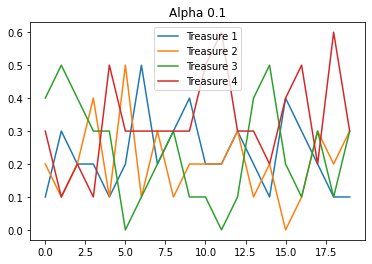

De Q waardes zijn respectievelijk: [23.640660838949252, 31.58343037620069, 50.97637629414148, 66.06344522827442]
Het totaal aantal punten is 8924.464642969433


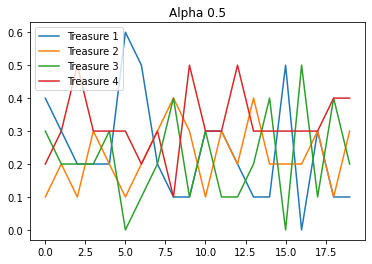

In [2]:
def q_learn(alpha, epsilon, trials):
    Q_list, means, choices = [0,0,0,0], [20, 30, 50, 70], [[],[],[],[]]
    SD, total_score = 4, 0
    for _ in range(trials):
        if random.random() > epsilon:
            Q = random.randint(0, len(Q_list) - 1)
        else:
            Qs = np.argwhere(Q_list == np.amax(Q_list)).flatten()
            if len(Qs) > 1:
                Q = np.random.choice(Qs)
            else:
                Q = Qs[0]
        reward = np.random.normal(means[Q], SD)
        Q_list[Q] += alpha*(reward - Q_list[Q])
        length = len(Q_list)
        for i in range(length):
            if i == Q:
                choices[i].append(1)
            else:
                choices[i].append(0)
        total_score += reward
    return (Q_list, total_score, choices)

for alpha in [0.1, 0.5]:
    Q_list, total_score, choices = q_learn(alpha, 0.1, 200)
    print("De Q waardes zijn respectievelijk: {}".format(Q_list))
    print("Het totaal aantal punten is {}".format(total_score))
    width = 10
    length = len(choices)
    for choice in range(length):
        choicelist_1 = np.array(choices[choice])
        result1 = choicelist_1[:(choicelist_1.size // width * width)].reshape(-1, width).mean(axis=1)
        plt.plot(result1, label="Treasure {}".format(choice+1))
    plt.title("Alpha {}".format(alpha))
    plt.legend()
    plt.show()
    
# Over het algemeen lijken de waardes van alpha 0.1 dichter bij de waardes te zitten van 'means'.
# Het model van alpha 0.1 is dus dichter bij de waarheid

### Q1.d (7 punten)

Laten we nu kijken hoe succesvol de verschillende strategieën (lees combinatie van parameter waardes) zijn. 

Schrijf nu een loop die `q_learn` 500 keer aanroept met een bepaalde parameter setting (en altijd 200 leerrondes) en sla telkens het totaal aantal punten op, zodat je aan het eind een lijst hebt van 500 totaal scores. 

Vergelijk het gemiddelde van die 500 totaalscores voor $\alpha=0.1$, $\alpha=0.3$ en $\alpha=0.5$ met $\epsilon=0.1$ voor alle experimenten. Leg uit hoe de verschillen tot stand komen. 


In [3]:
for alpha in [0.1, 0.3, 0.5]:
    scores = []
    for _ in range(500):
        scores.append(q_learn(alpha, 0.1, 200)[1])    
    print("Met alpha {} is de totale gemiddelde score: {}".format(alpha, np.average(scores)))

# De verschillen komen tot stand door de verschillende alpha-waardes, de alpha waarde bepaalt
# hoe snel een agent leert van zijn ervaringen, hoe hoger de alpha waarde hoe sneller er geleerd
# wordt en dus hoe effectiever de agent zal handelen

Met alpha 0.1 is de totale gemiddelde score: 9017.63526275836
Met alpha 0.3 is de totale gemiddelde score: 9024.711339872472
Met alpha 0.5 is de totale gemiddelde score: 9028.320735012046


# Exploration-Exploitation

We gaan nu dieper in op het exploration vs. exploitation dilemma. Laten we eerst kijken hoe verschillende e parameters uitwerking hebben op het aantal punten dat gewonnen wordt. Gebruik hier de functie van q_learn van de vorige vraag met $\epsilon=0.05$, $\epsilon=0.2$ en $\epsilon=0.6$ en met $\alpha=0.3$ voor alle experimenten. 

### Q2.a (7 punten)

Kijk voor elke parameter setting weer naar de gemiddelde totaal score van 500 leer episodes. Waar ligt ongeveer het optimale niveau van exploratie?

In [4]:
for epsilon in [0.05, 0.2, 0.6]:
    scores = []
    for _ in range(500):
        scores.append(q_learn(0.3, epsilon, 200)[1])    
    print("Met epsilon {} is de totale gemiddelde score: {}".format(epsilon, np.average(scores)))

# Het optimale niveau van exploratie lijkt (uit de gegeven epsilon-waardes om op te testen) rond de 0.6
# te liggen. Des te hoger de totaal behaalde score des te beter

Met epsilon 0.05 is de totale gemiddelde score: 8751.526515636384
Met epsilon 0.2 is de totale gemiddelde score: 9557.12205608527
Met epsilon 0.6 is de totale gemiddelde score: 11512.993216601897


### Q2.b (10 punten)

Pas nu `q_learn` zo aan dat de parameter $\epsilon$ gedurende een leer episode steeds kleiner wordt. Dit kan bijvoorbeeld door elke ronde $\epsilon$ met een vast percentage te verkleinen (denk aan iets tussen 0 en 10%), maar andere manieren zijn ook mogelijk. Sla dit model op als `q_learn_decay`.

In [20]:
def q_learn_decay(alpha, epsilon, trials, decay=0.05):
    Q_list, means, choices = [0,0,0,0], [20, 30, 50, 70], [[],[],[],[]]
    SD, total_score = 4, 0
    for _ in range(trials):
#         percentage verkleinen 5%
        epsilon *= (1-decay)
        if random.random() > epsilon:
            Q = random.randint(0, len(Q_list) - 1)
        else:
            Qs = np.argwhere(Q_list == np.amax(Q_list)).flatten()
            if len(Qs) > 1:
                Q = np.random.choice(Qs)
            else:
                Q = Qs[0]
        reward = np.random.normal(means[Q], SD)
        Q_list[Q] += alpha*(reward - Q_list[Q])
        length = len(Q_list)
        for i in range(length):
            if i == Q:
                choices[i].append(1)
            else:
                choices[i].append(0)
        total_score += reward
    return (Q_list, total_score, choices)

### Q2.c (7 punten)

Kijk nu naar een aantal beginwaarden voor parameter $\epsilon$, en kijk welk model meer punten kan verdienen in de taak (verken hier waarden van $\epsilon$ tussen .1 en .9). Gebruik weer het gemiddelde aantal punten over 500 leer episodes (en nog steeds 200 rondes per episode en $\alpha =  0.3$). Welk model is het beste en waarom denk je dat dit zo is?


In [21]:
for epsilon in [0.1, 0.4, 0.7]:
    scores = []
    for _ in range(500):
        scores.append(q_learn_decay(0.3, epsilon, 200)[1])    
    print("Met epsilon {} is de totale gemiddelde score: {}".format(epsilon, np.average(scores)))

# Voor optimale resultaten is een initiele waarde van e van ~0.8 het beste. De reden dat dit goed presteert
# is omdat de agent veel gokt wanneer hij nog niet veel weet (en dus sowieso geen optimale keuze zou kunnen
# maken) maar snel al minder begint te gokken. De andere modellen presteren slechter omdat ze in het begin
# hun keuzes te snel gaan baseren op vernomen waarderingen van Q waar ze eigenlijk meer zouden moeten 
# experimenteren om zo de juiste waardering van elke schatkist te achterhalen.

Met epsilon 0.1 is de totale gemiddelde score: 8520.846438962444
Met epsilon 0.4 is de totale gemiddelde score: 8634.070563476476
Met epsilon 0.7 is de totale gemiddelde score: 8707.244868766687


## Softmax

Een andere zeer populaire methode om exploratie te implementeren is de softmax regel. Deze kan gebruikt worden om de waarschijnlijkheid uit te rekenen dat de robot een specifieke kist kiest. Bijvoorbeeld de waarschijnlijkheid dat de robot op een bepaald moment kist 1 kiest is:

$$P(Q(1)) = \frac{e^{Q(1)*theta}}{\sum_s e^{(Q(s)*theta)}}$$

Voor kist 2:

$$P(Q(2)) = \frac{e^{(Q(2)*theta)}}{\sum_s e^{(Q(s)*theta)}}$$

En natuurlijk:

$$P(Q(1))+ P(Q(2)) +P(Q(3))+ P(Q(2)) = 1  (100\%)$$

want de robot kiest altijd een van de 4 opties, dus samen moet dat 100% kans zijn.

Implementeer nu de softmax regel in de `q_learn` functie en geef deze de naam `q_learn_softmax`.

* Gebruik elke ronde de $P(Q)$ informatie om de robot een kist te laten kiezen.
* Zorg ook dat elke ronde de waarschijnlijkheid $P(Q)$ van het kiezen van elke kist wordt opgeslagen zodat we hier later weer naar kunnen kijken. 

Gebruik dit model weer om de gemiddelde score voor 500 episodes voor verschillende waardes van theta (waardes tussen $0.01$ en $1$, op z'n minst 5) met elkaar te vergelijken, met wederom 200 rondes per episode en een $\alpha$ van $0.3$, gebruikmakende van de methode die we hier boven ontwikkeld hebben. 


### Q3.a (7 punten)

Wat is ongeveer de optimale waarde voor theta, hoe verhoud dit model zich tot de simpele versie van $\epsilon$-greedy? Hoe gedraagt het model zicht met een hoge waarde van theta, en hoe met een lage?

In [18]:
def softmax(Q, theta):
    return np.exp(Q * theta)/np.sum(Q * theta)

def q_learn_softmax(alpha, theta, trials):
    Q1 = Q2 = Q3 = Q4 = total_score = 0
    ops = [Q1, Q2, Q3, Q4]
    SD = 4
    means = {0: 20, 1:30, 2:50, 3:70}
    Q1_c = Q2_c = Q3_c = Q4_c = np.zeros(trials)
    choices = [Q1_c, Q2_c, Q3_c, Q4_c]
    P1 = P2 = P3 = P4 = 0.25
    chances = [P1, P2, P3, P4]
    probs = np.cumsum(chances)
    all_probs = []
    for i in range(trials):
        C = random.random()
        lower = 0
        for j in range(len(probs)):
            if lower <= C <= probs[j]:
                Q = probs[j]
                break
            else:
                lower = probs[j]
        reward = np.random.normal(means[j], SD)
        ops[j] = ops[j] + alpha*(reward - ops[j])
        choices[j][i] = 1
        probs = softmax(probs, theta)
        total_score += reward
        all_probs.append(probs)
    return ops, total_score, choices, all_probs

In [19]:
for theta in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]:
    scores = []
    for _ in range(500):
        scores.append(q_learn_softmax(0.3, epsilon, 200)[1])    
    print("Met theta {} is de totale gemiddelde score: {}".format(theta, np.average(scores)))

# De optimale resultaten werden behaald met een theta van ~0.3. De simpele versie van 𝜖 -greedy presteert slechter.
# Een hoge theta betekent dat de kansen van de schatkisten meer uit elkaar gaan liggen. Waardoor er minder wordt geëxplored.

Met theta 0.01 is de totale gemiddelde score: 6141.7070662963715
Met theta 0.1 is de totale gemiddelde score: 6153.634764714284
Met theta 0.2 is de totale gemiddelde score: 6143.3678468133785
Met theta 0.3 is de totale gemiddelde score: 6150.9476167200455
Met theta 0.4 is de totale gemiddelde score: 6149.2020969436935
Met theta 0.5 is de totale gemiddelde score: 6138.582028621566
Met theta 0.7 is de totale gemiddelde score: 6134.212492638369
Met theta 0.9 is de totale gemiddelde score: 6119.289454971853


## Upper Confidence Bound

Een andere zeer populaire methode om exploratie te implementeren is Upper Confidence Bound exploratie. Volgens deze regel krijgt een optie een exploratie bonus ($\eta$). Met andere woorden, hiermee wordt het model nieuwsgierig. Dit kan op verschillende manieren worden geimplementeerd, hier is een populaire versie UCB1:

$$Q'(action) = Q(action)+ \eta$$

$$\eta = \sqrt{\theta log(t)/N_t(action)}$$

Waarbij $t$ staat voor ronde nummer in het experiment, and $N_t$ het aantal keer in totaal dat een bepaalde keuze (action) gemaakt is. De parameter $\theta$ schaalt de grote van de exploratie bonus (met een hogere $\theta$ is de robot nieuwsgieriger). 

Het algoritme kiest in het begin van het experiment elke optie op z'n minst een keer, daarna pas wordt de exploratie bonus toegepast. 

Implementeer nu de upper confidence bound regel in de `q_learn` functie en geef deze de naam `q_learn_UCB`.

* Nadat de robot alle kisten eens geselecteerd heeft wordt de kist met de hoogste Q-waarde gekozen. Wanneer meerdere kisten deze maximale waarde hebben wordt een random keuze gemaakt. 
* Zorg ook dat elke ronde de exploratie bonus $\eta$ van elke kist wordt opgeslagen zodat we hier later weer naar kunnen kijken. 

Gebruik dit model weer om de gemiddelde score voor 500 episodes uit te rekenen voor een $\theta$ van 2 (default voor UCB1), met wederom 200 rondes per episode en een $\alpha$ van $0.3$, gebruikmakende van de functie die we hier boven ontwikkeld hebben. 


### Q4.a (7 punten)

Hoe verhoud dit model zich tot de simpele versie van $\epsilon$-greedy and soft-max? Leg uit waar het verschil in prestatie vandaan komt (kijk voor dit antwoord ook naar keuzes van het model, wat zie je?). 

### Q4.b (7 punten) slimme exploratie 
De exploration-exploitation trade-off wordt al voor lange tijd onderzocht en is een van de meest interessante problemen in reinforcement learning. In dit voorbeeld was het nogal makkelijk voor het algoritme om de oplossing te vinden omdat de 4 bandits redelijk veel verschilde van elkaar. Maar dit is niet altijd het geval. Kijk maar eens wat er gebeurd als je de standaard deviatie van vier naar 15 veranderd, of als je de means dichter bijelkaar zet. Dan zal je ook zien dat je een hogere exploratie waarde $\theta$ nodig hebt om tot de beste oplossing te komen.

* verander de bandits sd and means, en simuleer nu weer voor verschillende waardes van $\theta$ (waardes tussen $2$ en $100$, op zn minst 4) het alogritme, raporteer de beste waarde. 


In de simpele wereld van 4 bandits is nog uit te vinden welk niveau van exploratie optimaal is. Maar ook dit gaat veel tijd kosten, en de echte wereld is nog veel complexer en dus dan is het helemaal moeilijk om uit te zoeken wat nou het beste niveau van exploratie is. Dit blijft dus altijd een vraagstuk. Wel kan exploratie zelf al heel interessant gedrag vertonen als het slim is opgezet, UCB is hier maar een heel simpel voorbeeld van. Voor een veel complexer maar interessant voorbeeld is het leuk om te kijken naar: [Curiosity-driven Exploration by Self-supervised Prediction](https://pathak22.github.io/noreward-rl/). In dat recente paper probeert de agent ook de omgeving zo te verkennen dat het op zoek gaat naar states waar het meest over te leren valt, net als UCB. Door alleen heel nieuwsgierig te zijn zorgt het algoritme er al voor dat het heel ver kan komen in bepaalde games, zonder dat beloningen (bv punten) daar een belangrijke rol in spelen. 

## Model fitting

We gaan nu kijken naar de resultaten van een echt experiment. We hebben de data van een proefpersoon die het bovenstaande experiment heeft gespeeld. In de data file kunnen we terugvinden welke van de 4 opties zij gekozen had en hoeveel punten vervolgens elke trial verdient zijn. We gaan kijken met welke parameter waardes  Q-learning met een softmax choice rule het gedrag van de proefpersonen het beste kan voorspellen. De proefpersoon heeft 80 rondes gespeelt. 

Lees de data in uit *L4_data_1.txt* met behulp van [loadtxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html):
```python
with open("L4_data_1.txt") as f:
    data = np.loadtxt(f, dtype=int, delimiter="\t", skiprows=1)
```

Pas de `q_learn_softmax` functie aan zodat je deze op de data van de proefpersonen kan fitten. (Zie LC1 voor details over hoe functies gefit moeten worden, en pseudo code onderaan voor meer hulp).

Ga er van uit dat de proefpersonen enige ervaring hebben met dit type experiment en verwachten dat ze gemiddeld wel 40 punten per ronde gaan verdienen (alle Q’s starten op 40 ipv 0). 

We gaan voor het fitten van het model gebruik maken van minimize van scipy.optimize (`from scipy.optimize import minimize`) en we gaan proberen *Log Likelihood* te optimaliseren (mate van fit). 

Wat we op elke trial willen weten is wat de waarschijnlijkheid is dat het model dezelfde keuze maakte als de proefpersoon. Hoe groter de kans (likelihood) dat het model correct kiest, hoe beter het model "fit". 

In het databestand van de proefpersoon is te zien welke van de 4 kisten de proefpersoon koos. Dit kunnen we dan op elke ronde vergelijken met de corresponderende P(Q). In de eerste ronde zijn alle Q values nog gelijk dus zijn alle P(Q)s = .25.

Voor de eerste ronde geldt daarom automatisch dat de waarschijnlijkheid (likelihood) van de keuze van de proefpersoon ook .25 is, maar dat gaat veranderen naarmate er geleerd wordt. 

In het databestand staat ook voor elke ronde wat de uitkomst van een keuze was, deze moet gebruikt worden om vervolgens de Q-values aan te passen, net als we eerder gedaan hebben in de simulaties.

De output van deze functie moet de som van alle *log(P(Q(chosen)))* zijn. Let op vermenigvuldig deze som met -1. Dat doen we omdat minimize de functie probeert te minimaliseren , en we opzoek zijn naar de max LL (double negative). 

`**pseudo code**:`
```python
def q_learn_softmax_fit(params):
    alpha, theta, init_value = params
    nArms = 4
    Q = np.array([init_value]*nArms)
    LL = 0
    
    for row in data:
        probs <- calculate probability of chosing each option based on theta, Qvalues and softmax
        
        choice <- read choice from data (each trial is one row in file)
        outcome <- read outcomee of choice from data
        
        LL += np.log(probs[choice])
        
        Q[choice] <- update Q value
    
    # Scaled for minimize function
    return -1*LL

# minimize takes a few arguments (function, array of initial parameter values, minimization methods,
# bounds are the bounds on each parameter; use bounds (same, same) to fix parameter to a single value
res = minimize(q_learn_softmax_fit, np.array([0.5, 0.5, 40]), method='SLSQP',
               bounds=[(0,1), (0,10), (40,40)], options={'disp':True, 'ftol':1e-16})
```

### Q5.a (7 punten)

Welke parameterwaarden fitten de data van de proefpersoon het beste? Probeer eens een hogere start waarde voor Q values (>80) en hoe beïnvloed dit de model fit? 

Minimize geeft ook de uiteindelijke summed LL (negatief) van het best fittende model. Deze score kan je weer terugrekenen naar een gemiddelde likelihood  per trail . Dus de kans dat het model de juiste trial koos. Doe dit en beoordeel de uitkomst. (hint: (inverse van log(x) = $e$(x) en output is summed dus delen door aantal trials). 

### Q5.b (7 punten)

Herschrijf de functie nogmaals en zorg ervoor dat de initialisatie van de Q waarde (de start Q waarden) ook een vrije parameter wordt. Als je dit doet kan je de start waarde vinden die het best bij het gedrag van de proefpersoon past. Rapporteer, en interpreteer deze waarde. En zorgt dit ook voor een betere model fit?

### Q5.c (7 punten)

Als we de functie een klein beetje herschrijven kunnen we deze gebruiken om in het hoofd van de proefpersoon te kijken. Bijvoorbeeld we willen nu weten welke Q-values zij aan de verschillende bandits toekennen. 

Hiervoor is alleen een kleine verandering nodig, waarbij de functie nu niet meer de LogLikelihood als output heeft maar de lijst met Q values. Pas de functie `q_learn_softmax_fit` aan zodat deze de Q-values returnt en noem de nieuwe functie `q_learn_fitted_model`. Zorg hierbij dat de `params` lijst van argumenten ook hetzelfde blijft als bij de `q_learn_softmax_fit`.

Nu hoef je ook niet meer de functie te fitten of minimalizeren maar alleen aan te roepen, gebruikmakende van de beste gevonden `params` van de vorige stap.

`q_learn_fitted_model(res.x)`

Rapporteer de Q values van deze proefpersoon. In werkelijkheid waren de gemiddelde waardes van de bandits (50, 30, 20, 80). Hoe wijkt de proefpersoon hier van af en hoe is dat te verklaren (hint: kijk naar keuze gedrag, dus de selectie van bandits, in de data file)?
